# Project 6 Times Series Analysis (TSA) of Housing Market 

# Imports

In [1]:
!ls

Chicago_data.ipynb                 Scripts
Data                               Server Command
LICENSE                            __pycache__
Project_6_TSA_Housing_in_NYC.ipynb images
README.md                          private.py


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings(action='once')

In [3]:
#Quick Look on the Sotred DataFiles

# Data Cleaning

All .CSVs in the `Data` will be selected and processed to be in a pandas DataFrame with DateTimeIndex suitable for TSA. 

In [4]:
from os import listdir
path = "Data/NYC/"
#get all cvs
csvs = list(filter(lambda x: ".csv" in x , listdir(path)))

#convert them into DFs and store them with their names
dfs = dict(zip(csvs,[pd.read_csv(path+name) for name in csvs]))

Inspecting the Data:

In [5]:
for df in dfs.keys():
    print(dfs[df].head(5))
    print(dfs[df].tail(5))
    print("------------")
    print()

         DATE    NYNGSP
0  1997-01-01  718322.5
1  1998-01-01  745223.7
2  1999-01-01  793721.1
3  2000-01-01  838660.3
4  2001-01-01  877149.3
          DATE     NYNGSP
17  2014-01-01  1427812.7
18  2015-01-01  1487789.4
19  2016-01-01  1541524.4
20  2017-01-01  1598457.0
21  2018-01-01  1676350.2
------------

         DATE    NYXRCSA
0  1995-01-01  74.947242
1  1995-02-01  74.540868
2  1995-03-01  73.950593
3  1995-04-01  73.262124
4  1995-05-01  73.311316
           DATE     NYXRCSA
287  2018-12-01  275.158802
288  2019-01-01  273.894281
289  2019-02-01  272.510320
290  2019-03-01  273.920370
291  2019-04-01  272.758559
------------

         DATE  NEWY636URN
0  1990-01-01         5.4
1  1990-02-01         5.5
2  1990-03-01         5.1
3  1990-04-01         4.9
4  1990-05-01         5.0
           DATE  NEWY636URN
348  2019-01-01         4.4
349  2019-02-01         4.3
350  2019-03-01         3.9
351  2019-04-01         3.2
352  2019-05-01         3.5
------------



The "NYNGSP" data is annual whereas "NYXRCSA" and "NEWY636URN" are on a monthly basis.

In order to join the Data the dates have to be set to a common scale and date range. The bottle neck here is the GDP Data. It will be inflated to monthly data and then the Range from 1997 onwards is selected.

Process the data and rename it for better readability

In [6]:
from Scripts.functions import preprocess
preprocessed = [preprocess(dfs[df]) for df in dfs.keys()]

/Users/pietrassyk/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/pietrassyk/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/pietrassyk/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/pietrassyk/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: Depreca

In [7]:
nyc = pd.concat(preprocessed,axis = 1)["1997":"2017"]
nyc.columns = ["GDP", "PriceIndex" , "Unemployment" ]

# Exploratory Data Analysis (EDA)

The data is visually inspected to determine trends,  seasonality and 

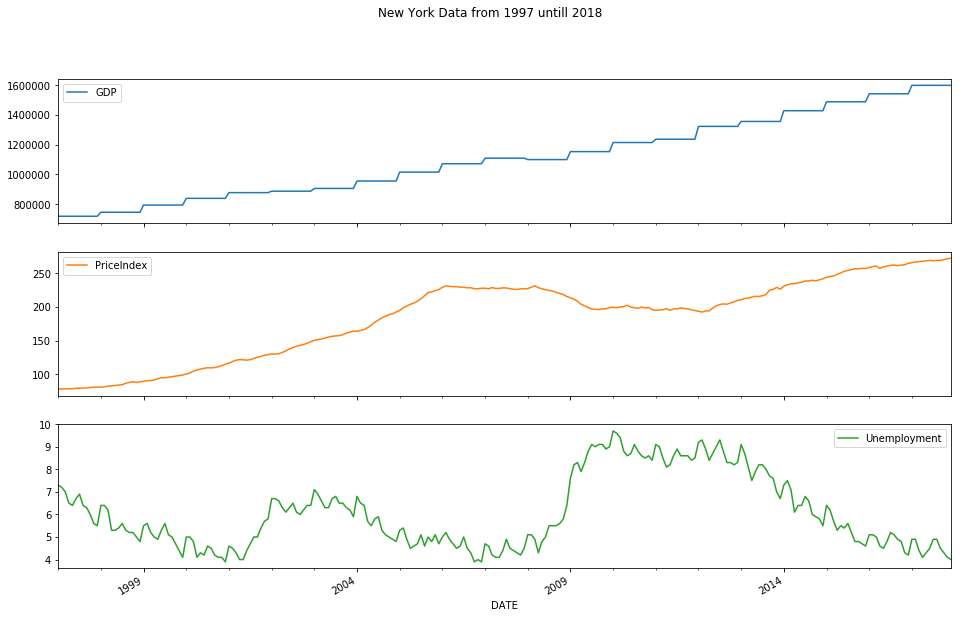

In [8]:
nyc.plot(subplots = True, figsize=(16,10), legend = True, title = "New York Data from 1997 untill 2018");

The above plot shows:

|Name|Trend|Seasonality|
|:----|-----|-----------|
|GDP|upwards|none|
|Prices|upwards|none|
|Unemployment|steady|yearly|

# Feature Engineering

## Stationarity

As shown in the previous section, there are Trends and Seasonality that have to be dealt with.
In order to remove trends and seasonality, the data needs to be transformed further. The goal is to make each series stationary.

Dickey-Fuller-Test is used to determine how stationary a series is. The critical value here is the p-value. If it is less than the confidence level of 0.05 we consider the series to be stationary.

### GDP

In [ ]:
from functions import eval_stationary

In [ ]:
#original Value for the GDP column:
nyc["GDP"].plot(figsize=(16,4));
eval_stationary(nyc["GDP"])

In [ ]:
#applying rolling mean
window = 2
new_name = "GDP"+"_roll_"+ str(window)
nyc[new_name] = nyc["GDP"] - nyc["GDP"].rolling(window = window).mean()
eval_stationary(nyc[new_name])

#plot result
nyc[new_name].plot(figsize=(16,4));

### Casey Shiller Index (CSI)

In [ ]:
nyc["PriceIndex"].plot(figsize=(16,4));
plt.show()
eval_stationary(nyc["PriceIndex"])

#applying rolling mean
window = 2
new_name = "PriceIndex"+"_roll_"+ str(window)
nyc[new_name] = nyc["PriceIndex"] - nyc["PriceIndex"].rolling(window = window).mean()

#plot result
nyc[new_name].plot(figsize=(16,4));
eval_stationary(nyc[new_name])

### Unemployment rate

In [ ]:
nyc["Unemployment"].plot(figsize=(16,4));
plt.show()
eval_stationary(nyc["Unemployment"])

#applying rolling mean
window = 3
new_name = "Unemployment"+"_roll_"+ str(window)
nyc[new_name] = nyc["Unemployment"] - nyc["Unemployment"].rolling(window = window).mean()

#plot result
nyc[new_name].plot(figsize=(16,4));
eval_stationary(nyc[new_name])

## Train Test Split

In [ ]:
#perform a 80/20 train test split
import math
split = math.floor(len(nyc)*0.8)
end = len(nyc)

In [ ]:
target = "PriceIndex"
X_train = nyc.copy().dropna().iloc[:split]
X_test = nyc.copy().dropna().iloc[split:]
y_train = None
y_test = None

## Feature Correlation

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index)
#X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

In [ ]:
list(nyc.columns)

In [ ]:
plot_df = X_train[['GDP_roll_2',
               'PriceIndex_roll_2',
               'Unemployment_roll_3']]

In [ ]:
plot_df.plot(subplots = False, figsize=(16,10), title = "Stationary Features");

In [ ]:
plot_df.corr()

## Autocorrelation

for col in plot_df.columns:
    plt.figure( figsize = (16,6))
    plt.title(f"Autocorrelation of {col}")
    pd.plotting.autocorrelation_plot(plot_df[col]);
    plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

In [ ]:
rcParams['figure.figsize'] = 14, 5

for col in plot_df.columns:
    print(col)
    plot_acf(plot_df[col],lags=50);

In [ ]:
for col in plot_df.columns:
    print(col)
    plot_pacf(plot_df[col],lags=60);

# Feature Selection

In [ ]:
nyc.corr()

# Modeling

For forecasting the future CSI movement the following models will be tested:
+ ARIMA
+ SARIMA
+ multivariant ARIMA

After each test model performance is evaluated by ________ and ultimately a final model is chosen.

## ARIMA

In [ ]:
import statsmodels.api as sm
import sklearn.metrics as metrics

In [ ]:
model_df = X_train.copy()
fore_cast_span = end-split

`order = (p , d, q)`
+ p = #autoregressive degrees --> auto regression plot (where most extreme)
+ d = nonseasonal differences --> amount of differences
+ q = lagged forecast errors --> amount if difference where the error is compute`

In [ ]:
#fit the model
mod = sm.tsa.ARIMA(model_df[target],order=(2,1,0), dates=model_df.index)
res = mod.fit()

#predict
forecast = pd.concat([X_train,X_test], axis = 0)
forecast['forecast'] = res.predict(start = split, end= end, dynamic=True, typ='levels')  

#evaluate
y_pred = forecast.dropna()["forecast"]
y_true = forecast.dropna()[target]
RMSE = round(np.sqrt(metrics.mean_squared_error(y_pred, y_true))/y_true.std(),3)

#plot
forecast[[target, 'forecast']].plot(figsize=(8, 6))
print(f"RMSE for Model-Forecast : {RMSE}")

In [ ]:
res.summary()

## ARIMA with Exog

In [ ]:
#define exog
exogs = ["Unemployment"]
if exogs:
    exog = X_train[exogs]

#fit the model
mod = sm.tsa.ARIMA(model_df[target],order=(2,1,0), dates=model_df.index, exog=exog)
res = mod.fit()

#predict
forecast = pd.concat([X_train,X_test], axis = 0)
forecast['forecast'] = res.predict(start = split, end= end, dynamic=True, typ='levels', exog=exog)  

#evaluate
y_pred = forecast.dropna()["forecast"]
y_true = forecast.dropna()[target]
RMSE = round(np.sqrt(metrics.mean_squared_error(y_pred, y_true))/y_true.std(),3)

#plot
forecast[[target, 'forecast']].plot(figsize=(8, 6))
print(f"RMSE for Model-Forecast : {RMSE} standard derivations")

In [ ]:
res.summary()

# Hyperparameter Tuning

In [ ]:
import itertools as it
i

In [ ]:
p = list(range(1,3))
d = list(range(0,3))
q = list(range(4))

pdq = list(it.product(p,d,q))
PDQ = list(it.product(p,d,q,[12]))

In [ ]:
out = []
i= 0
for arima in pdq:
    for S in PDQ:
        print(f"Fit {i}/{len(pdq)*len(PDQ)}", end = "\r")
        try:
            model = sm.tsa.SARIMAX(X_train[target], 
                               order = arima , 
                               seasonal_order=S, 
                               enforce_stationarity= False, 
                               enforce_invertibility=False)
            output = model.fit()
            res = output.aic
        except:
            res = "Error"
        i+=1
        out.append({"order": arima,
                   "seasonal_order" : S,
                   "AIC": res})


In [ ]:
out

In [ ]:
model = sm.tsa.SARIMAX(model_df[target], dates = model_df.index, enforce_stationarity= False)
res = model.fit()
res.aic
